# Model 5: Neuromodulated Quantum Synapse - Complete Test Suite
# This notebook integrates all Model 4 improvements with Model 5 enhancements

# %% [markdown]
# # Model 5: Neuromodulated Quantum Synapse Test Suite
# 
# This notebook runs comprehensive tests for Model 5, which includes:
# - All Model 4 functionality (templates, calcium dynamics, pH modulation)
# - ATP-phosphate dynamics with J-coupling
# - Dimer vs trimer pathways
# - Dopamine modulation
# - Quantum coherence tracking
# - Enhanced spatial visualization

In [37]:
# %% Cell 1: Imports and Setup
from google.cloud import storage
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from io import BytesIO
import warnings
import time 
warnings.filterwarnings('ignore')

# Import BigQuery
import subprocess
import sys
try:
    from google.cloud import bigquery
    print("✅ google-cloud-bigquery already installed")
except ImportError:
    print("Installing google-cloud-bigquery...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "google-cloud-bigquery"])
    print("✅ Installation complete")
    from google.cloud import bigquery

import uuid

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')

# Configure matplotlib for notebook display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("✅ Imports complete")
print(f"📅 Test run initiated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ google-cloud-bigquery already installed
✅ Imports complete
📅 Test run initiated: 2025-08-24 18:28:11


In [38]:
# %% Cell 2: Initialize connections and session
# Initialize connection to buckets
client = storage.Client(project='quantum-brain-models')
results_bucket = client.bucket('quantum-sfa-results')

# Initialize BigQuery client
bq_client = bigquery.Client(project='quantum-sfa-phd')
print("✅ BigQuery client initialized")

# Create a session ID for this test run
SESSION_ID = datetime.now().strftime('%Y%m%d_%H%M%S')
SESSION_NAME = "model5_test_1"  # Change this for different test runs

print(f"📁 Session: {SESSION_NAME}_{SESSION_ID}")

def save_results_and_figures(results, test_name, figures=None):
    """Enhanced save function with proper organization"""
    timestamp = datetime.now().strftime('%H%M%S')  # Just time since date is in session
    
    # Add metadata
    results['metadata'] = {
        'test_name': test_name,
        'timestamp': datetime.now().isoformat(),
        'model_version': '5.0',
        'session_id': SESSION_ID,
        'grid_size': getattr(globals().get('params', None), 'grid_size', 50)
    }
    
    # Calculate summary metrics if available
    if 'posner_field' in results and 'posner_field' is not None:
        results['summary'] = {
            'peak_posner_nM': np.max(results['posner_field']) * 1e9,
            'mean_posner_nM': np.mean(results['posner_field']) * 1e9,
        }
    
    # Convert numpy arrays to lists for JSON
    data_for_json = {}
    for key, value in results.items():
        if isinstance(value, np.ndarray):
            data_for_json[key] = value.tolist()
        elif isinstance(value, dict):
            # Recursively convert nested dicts
            nested = {}
            for k, v in value.items():
                if isinstance(v, np.ndarray):
                    nested[k] = v.tolist()
                else:
                    nested[k] = v
            data_for_json[key] = nested
        else:
            data_for_json[key] = value
    
    # Organized path structure: model5/SESSION/test_name/files
    base_path = f"model5/{SESSION_NAME}_{SESSION_ID}/{test_name}_{timestamp}"
    
    # Save data
    data_path = f"{base_path}/data.json"
    blob = results_bucket.blob(data_path)
    blob.upload_from_string(json.dumps(data_for_json, indent=2, default=str))
    print(f"✅ Data saved: {data_path}")
    
    # Save current matplotlib figure
    if plt.get_fignums():
        fig_path = f"{base_path}/figure.png"
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)
        
        blob = results_bucket.blob(fig_path)
        blob.upload_from_file(buf, content_type='image/png')
        print(f"✅ Figure saved: {fig_path}")
    
    # Save additional figures if provided
    if figures:
        for i, fig in enumerate(figures):
            fig_path = f"{base_path}/figure_{i}.png"
            buf = BytesIO()
            fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
            buf.seek(0)
            
            blob = results_bucket.blob(fig_path)
            blob.upload_from_file(buf, content_type='image/png')
            print(f"✅ Extra figure {i} saved: {fig_path}")
    
    return base_path

def save_test_to_bigquery(results, test_name, session_id, session_name, params=None):
    """Save test results to BigQuery tables"""
    
    # Generate unique test ID
    test_id = str(uuid.uuid4())
    
    # Prepare row for test_runs table
    test_run_row = {
        'test_id': test_id,
        'session_id': session_id,
        'session_name': session_name,
        'model_name': 'DynamicNanoreactor',
        'model_version': '5.0',
        'test_name': test_name,
        'timestamp': datetime.now().isoformat(),
        'stim_protocol': results.get('stim_protocol', 'baseline'),
        'duration': results.get('duration', 0.0),
        
        # Core metrics - handle both nM and M units
        'peak_posner_nM': results.get('peak_posner_nM', results.get('peak_nM', 0.0)),
        'mean_posner_nM': results.get('mean_posner_nM', results.get('mean_nM', 0.0)),
        'peak_pnc_nM': results.get('peak_pnc_nM', results.get('mean_pnc', 0.0) * 1e9),
        'mean_pnc_nM': results.get('mean_pnc_nM', results.get('mean_pnc', 0.0) * 1e9),
        'peak_calcium_uM': results.get('peak_calcium_uM', results.get('mean_calcium_uM', 0.0)),
        'mean_calcium_uM': results.get('mean_calcium_uM', 0.0),
        
        # Model 5 specific metrics
        'peak_dimer_nM': results.get('peak_dimer_nM', 0.0),
        'peak_trimer_nM': results.get('peak_trimer_nM', 0.0),
        'max_j_coupling': results.get('max_j_coupling', 0.0),
        'dopamine_peak_nM': results.get('dopamine_peak_nM', 0.0),
        
        # Spatial metrics
        'hotspot_lifetime': results.get('hotspot_lifetime', 0.0),
        'spatial_heterogeneity': results.get('spatial_heterogeneity', 0.0),
        'n_hotspots': results.get('n_hotspots', 0),
        'spatial_cv': results.get('spatial_cv', 0.0),
        
        # Conservation metrics
        'calcium_conservation': results.get('calcium_conservation', 1.0),
        'phosphate_conservation': results.get('phosphate_conservation', 1.0),
        
        # Template and fusion metrics
        'templates_occupied': results.get('templates_occupied', 0),
        'fusion_events': results.get('fusion_events', 0),
        
        # GCS paths
        'gcs_data_path': f"gs://quantum-sfa-results/model5/{session_name}_{session_id}/{test_name}/data.json",
        'gcs_hdf5_path': f"gs://quantum-sfa-results/model5/{session_name}_{session_id}/{test_name}/data.h5",
        'gcs_json_path': f"gs://quantum-sfa-results/model5/{session_name}_{session_id}/{test_name}/results.json",
        
        # Test result
        'test_passed': results.get('test_passed', True)
    }
    
    # Insert into test_runs table
    table_id = 'quantum-sfa-phd.model_results.test_runs'
    table = bq_client.get_table(table_id)
    
    import json
    test_run_row_json = json.loads(json.dumps(test_run_row, default=str))
    errors = bq_client.insert_rows_json(table, [test_run_row_json])
    
    if errors:
        print(f"❌ Error inserting test run: {errors}")
    else:
        print(f"✅ Test run saved to BigQuery: {test_id}")
    
    # Save parameters if provided
    if params:
        param_row = {
            'test_id': test_id,
            'grid_size': params.get('grid_size', 50),
            'active_zone_radius': params.get('active_zone_radius', 0.0),
            'cleft_width': params.get('cleft_width', 0.0),
            'n_channels': params.get('n_channels', 0),
            'channel_current': params.get('channel_current', 0.0),
            'channel_open_rate': params.get('channel_open_rate', 0.0),
            'channel_close_rate': params.get('channel_close_rate', 0.0),
            'ca_baseline': params.get('ca_baseline', 0.0),
            'po4_baseline': params.get('po4_baseline', 0.0),
            'atp_concentration': params.get('atp_concentration', 0.0),
            'pnc_baseline': params.get('pnc_baseline', 0.0),
            'D_calcium': params.get('D_calcium', 0.0),
            'D_phosphate': params.get('D_phosphate', 0.0),
            'D_pnc': params.get('D_pnc', 0.0),
            'D_posner': params.get('D_posner', 0.0),
            'k_complex_formation': params.get('k_complex_formation', 0.0),
            'k_complex_dissociation': params.get('k_complex_dissociation', 0.0),
            'k_pnc_formation': params.get('k_pnc_formation', 0.0),
            'k_pnc_dissolution': params.get('k_pnc_dissolution', 0.0),
            'pnc_size': params.get('pnc_size', 0.0),
            'pnc_max_concentration': params.get('pnc_max_concentration', 0.0),
            'templates_per_synapse': params.get('templates_per_synapse', 0),
            'n_binding_sites': params.get('n_binding_sites', 0),
            'k_pnc_binding': params.get('k_pnc_binding', 0.0),
            'k_pnc_unbinding': params.get('k_pnc_unbinding', 0.0),
            'template_accumulation_range': params.get('template_accumulation_range', 0),
            'template_accumulation_rate': params.get('template_accumulation_rate', 0.0),
            'k_fusion_attempt': params.get('k_fusion_attempt', 0.0),
            'fusion_probability': params.get('fusion_probability', 0.0),
            'pnc_per_posner': params.get('pnc_per_posner', 0),
            'k_atp_hydrolysis': params.get('k_atp_hydrolysis', 0.0),
            'ph_activity_shift': params.get('ph_activity_shift', 0.0),
            'f_hpo4_ph73': params.get('f_hpo4_ph73', 0.0),
            'gamma_ca': params.get('gamma_ca', 0.0),
            'gamma_po4': params.get('gamma_po4', 0.0),
            'template_factor': params.get('template_factor', 0.0),
            'confinement_factor': params.get('confinement_factor', 0.0),
            'electrostatic_factor': params.get('electrostatic_factor', 0.0),
            'membrane_concentration_factor': params.get('membrane_concentration_factor', 0.0),
            'dt': params.get('dt', 0.0),
            'save_interval': params.get('save_interval', 0.0),
            'kr_posner': params.get('kr_posner', 0.0),
            
            # Model 5 specific parameters
            'J_PP_atp': params.get('J_PP_atp', 20.0),
            'T2_base_dimer': params.get('T2_base_dimer', 100.0),
            'T2_base_trimer': params.get('T2_base_trimer', 1.0),
            'dopamine_baseline': params.get('dopamine_baseline', 20e-9),
            'dopamine_peak': params.get('dopamine_peak', 1.6e-6),
            'k_dimer_formation': params.get('k_dimer_formation', 1e-4),
            'k_trimer_formation': params.get('k_trimer_formation', 1e-5),
        }
        
        param_table_id = 'quantum-sfa-phd.model_results.parameters'
        param_table = bq_client.get_table(param_table_id)
        errors = bq_client.insert_rows_json(param_table, [param_row])
        
        if errors:
            print(f"❌ Error inserting parameters: {errors}")
        else:
            print(f"✅ Parameters saved to BigQuery")
    
    return test_id

# Enhanced save function that includes BigQuery
def save_results_with_bigquery(results, test_name, figures=None):
    """Save results to both GCS and BigQuery"""
    
    # Your existing GCS save logic
    timestamp = datetime.now().strftime('%H%M%S')
    
    # Save to GCS first (your existing code)
    base_path = save_results_and_figures(results, test_name, figures)
    
    # Extract model parameters if available
    params = results.get('params') if hasattr(results, 'get') else None
    if hasattr(results, '__dict__') and 'params' in results.__dict__:
        params = results.params if hasattr(results.params, 'get') else vars(results.params)
    
    # Save to BigQuery
    test_id = save_test_to_bigquery(
        results if isinstance(results, dict) else vars(results),
        test_name,
        SESSION_ID,  # From your existing code
        SESSION_NAME,  # From your existing code
        params
    )
    
    print(f"✅ Complete save: GCS path={base_path}, BQ test_id={test_id}")
    
    return base_path, test_id

# Query function to check your data
def query_recent_tests(limit=10):
    """Query recent test results from BigQuery"""
    
    query = f"""
    SELECT 
        test_id,
        test_name,
        timestamp,
        peak_posner_nM,
        mean_posner_nM,
        test_passed
    FROM `quantum-sfa-phd.model_results.test_runs`
    ORDER BY timestamp DESC
    LIMIT {limit}
    """
    
    query_job = bq_client.query(query)
    results = query_job.result()
    
    print(f"\n📊 Recent {limit} tests:")
    print("-" * 80)
    for row in results:
        print(f"{row.test_name}: {row.peak_posner_nM:.2f} nM (passed: {row.test_passed})")
    
    return results

print("✅ BigQuery integration ready!")
print("Use save_results_with_bigquery() to save to both GCS and BigQuery")


✅ BigQuery client initialized
📁 Session: model5_test_1_20250824_182815
✅ BigQuery integration ready!
Use save_results_with_bigquery() to save to both GCS and BigQuery


In [39]:
# %% Cell 3: Initialize Model 5
import sys
import os

# Go up one level from notebooks to find src
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
parent_dir = os.path.dirname(current_dir)  # Go up from notebooks to project root
src_path = os.path.join(parent_dir, 'src')
models_path = os.path.join(parent_dir, 'src', 'models')

# Add the paths
if models_path not in sys.path:
    sys.path.insert(0, models_path)
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"Adding models path: {models_path}")

# Now import from the model5 file
from model5_neuromodulated_quantum_synapse import Model5Parameters, QuantumSynapseModel5
import time
# Initialize parameters
params = Model5Parameters()

# Initialize model
model = QuantumSynapseModel5(params)

print("✅ Model 5 initialized from model5_neuromodulated_quantum_synapse.py")
print(f"  Grid size: {params.grid_size}")
print(f"  Channels: {params.n_channels}")
print(f"  Templates: {params.templates_per_synapse}")
print(f"  J-coupling (ATP): {params.J_PP_atp} Hz")
print(f"  Dimer T2: {params.T2_base_dimer} s")
print(f"  Trimer T2: {params.T2_base_trimer} s")


Adding models path: /Users/sarahdavidson/posner_quantum_dynamics/src/models
✅ Model 5 initialized from model5_neuromodulated_quantum_synapse.py
  Grid size: 50
  Channels: 6
  Templates: 15
  J-coupling (ATP): 20.0 Hz
  Dimer T2: 100.0 s
  Trimer T2: 1.0 s


✅ Data saved: model5/model5_test_1_20250824_182815/test_1_baseline_182820/data.json
✅ Figure saved: model5/model5_test_1_20250824_182815/test_1_baseline_182820/figure.png
✅ Test run saved to BigQuery: 0637e70a-5426-4309-a846-6489f1688fc8
✅ Complete save: GCS path=model5/model5_test_1_20250824_182815/test_1_baseline_182820, BQ test_id=0637e70a-5426-4309-a846-6489f1688fc8

Test 1: ✅ PASSED (2.84s)


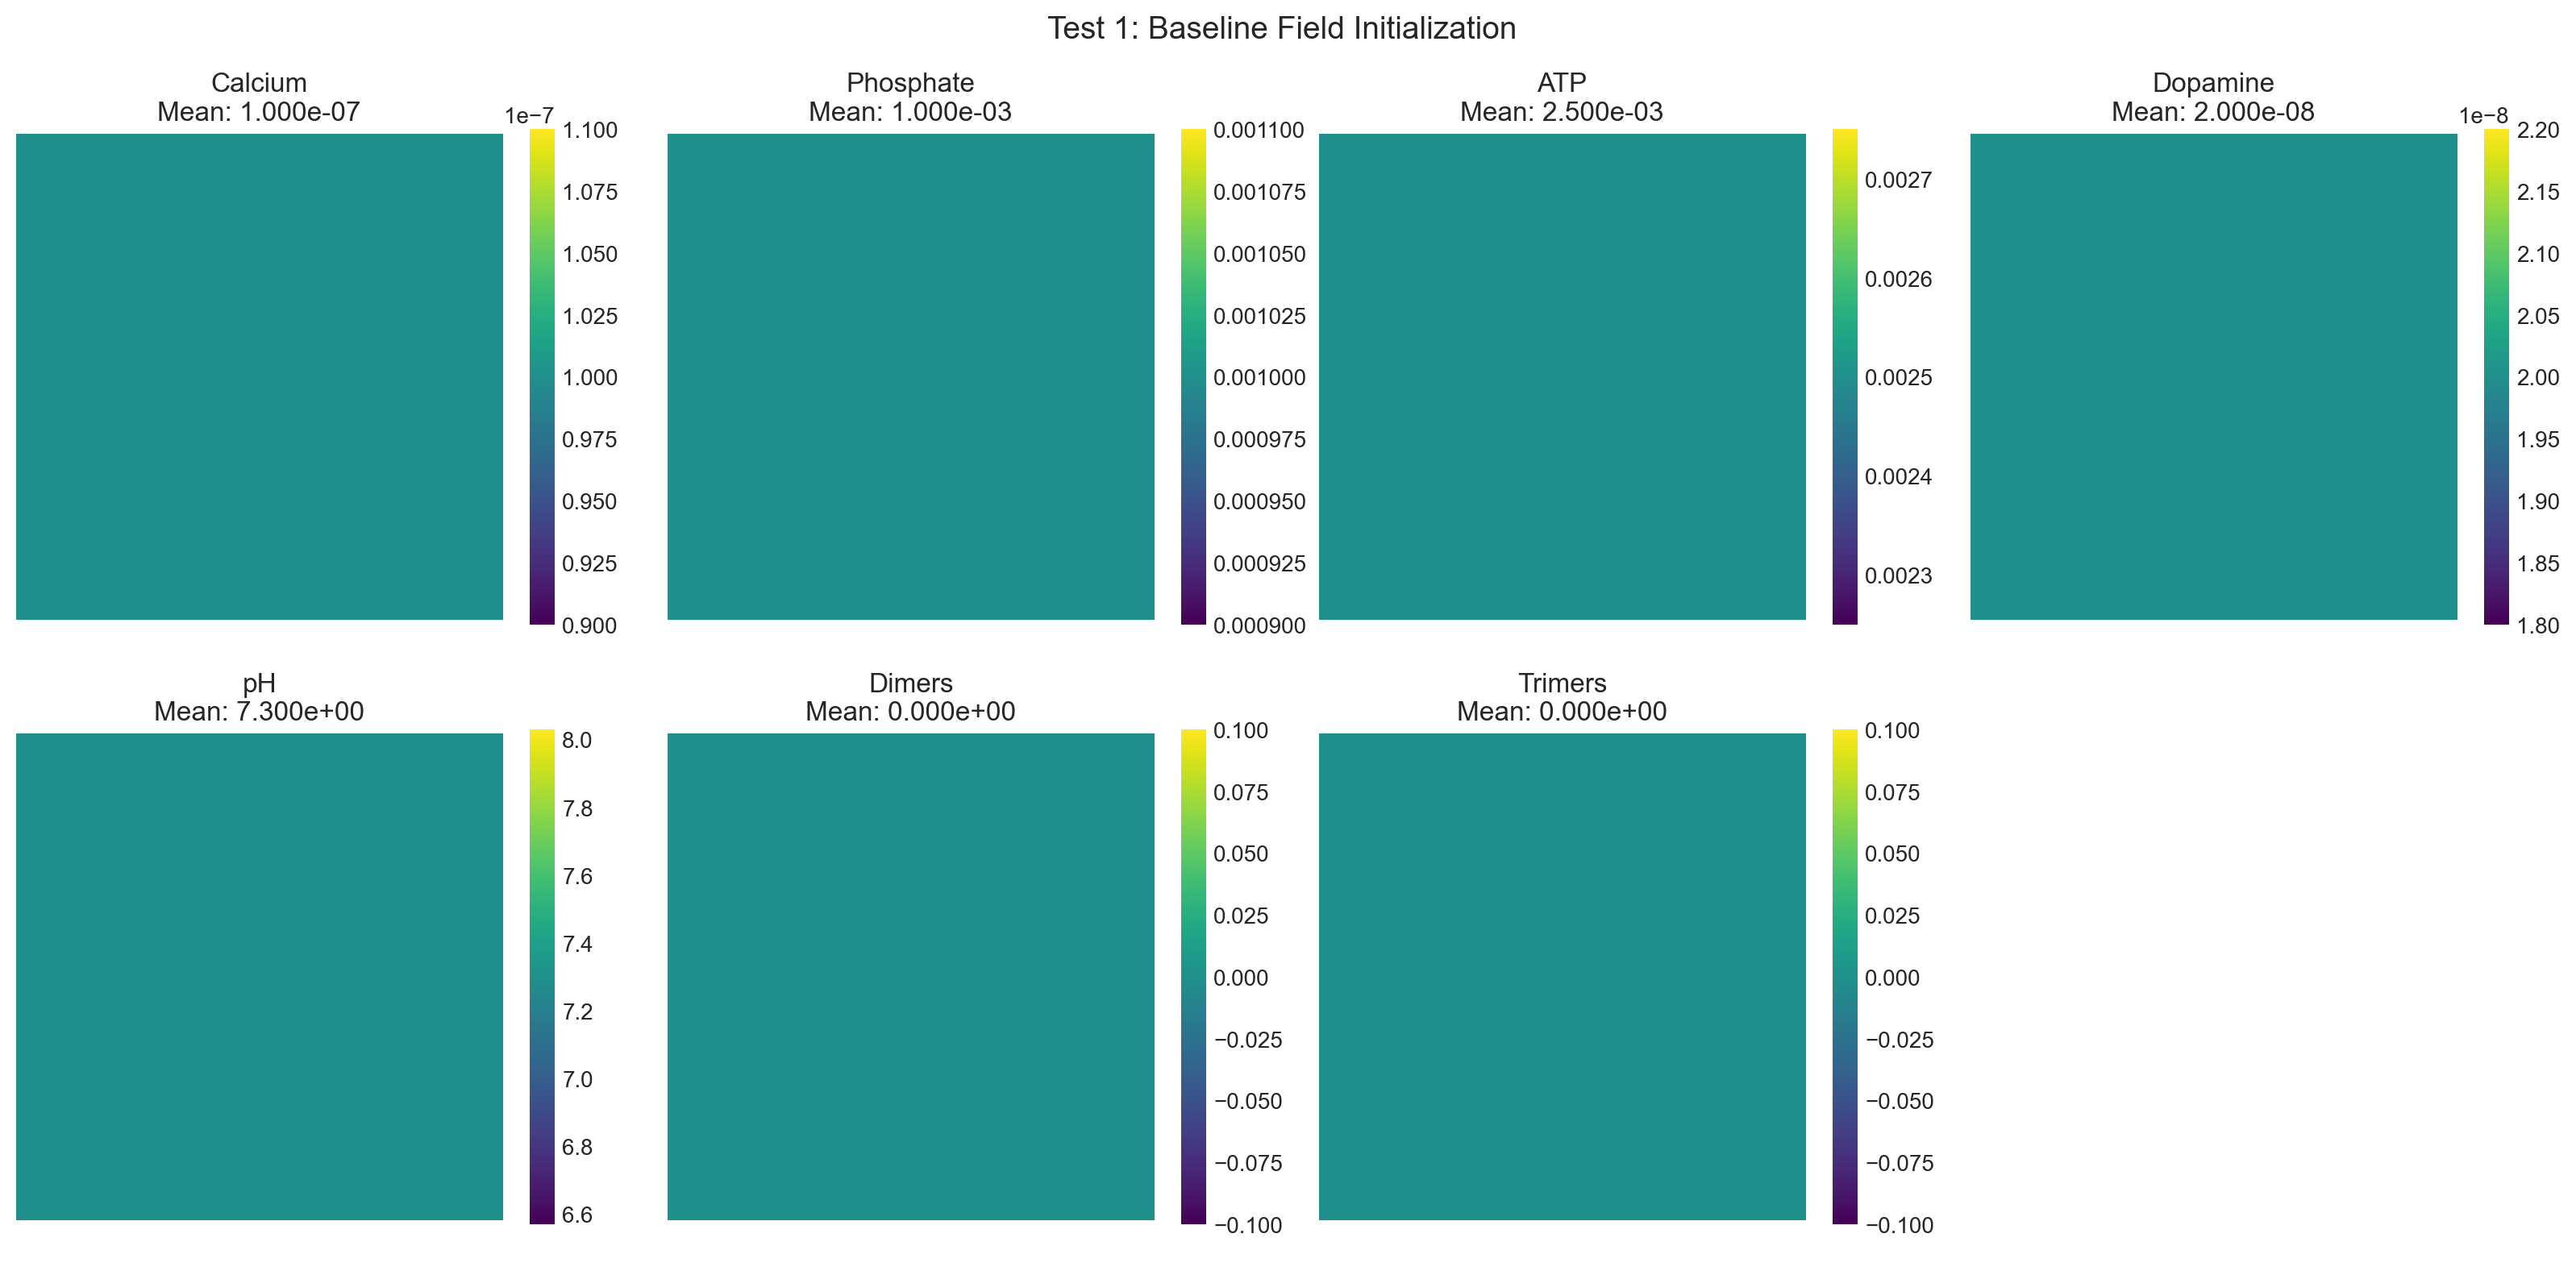

In [40]:
# %% Cell 4: Test 1 - Baseline Initialization


def test_baseline_initialization():
    """Test all fields initialize correctly"""
    
    checks = {
        'calcium': (model.calcium_field, model.params.ca_baseline, "Calcium"),
        'phosphate': (model.phosphate_field, 1e-3, "Phosphate"),
        'ATP': (model.atp_field, model.params.atp_baseline, "ATP"),
        'dopamine': (model.dopamine_field, model.params.dopamine_baseline, "Dopamine"),
        'pH': (model.pH_field, model.params.pH_baseline, "pH"),
        'dimers': (model.dimer_field, 0.0, "Dimers"),
        'trimers': (model.trimer_field, 0.0, "Trimers")
    }
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Test 1: Baseline Field Initialization', fontsize=14)
    axes = axes.flatten()
    
    all_passed = True
    metrics = {}
    
    for idx, (name, (field, expected, label)) in enumerate(checks.items()):
        mean_val = np.mean(field)
        
        if name in ['dimers', 'trimers']:
            passed = np.allclose(mean_val, expected, atol=1e-10)
        else:
            passed = np.allclose(mean_val, expected, rtol=0.01)
        
        all_passed = all_passed and passed
        metrics[name] = float(mean_val)
        
        # Plot field
        if idx < len(axes):
            im = axes[idx].imshow(field, cmap='viridis')
            axes[idx].set_title(f"{label}\nMean: {mean_val:.3e}")
            axes[idx].axis('off')
            plt.colorbar(im, ax=axes[idx], fraction=0.046)
    
    # Hide unused subplot
    if len(checks) < len(axes):
        axes[-1].axis('off')
    
    plt.tight_layout()
    
    # Prepare results for your save function
    results = {
        'test_passed': all_passed,
        'test_name': 'baseline_initialization',
        **metrics  # Add all field means as metrics
    }
    
    # Save using your function
    save_results_with_bigquery(results, 'test_1_baseline')
    
    return all_passed

# Run test
start_time = time.time()
test1_passed = test_baseline_initialization()
execution_time = time.time() - start_time

status = "✅ PASSED" if test1_passed else "❌ FAILED"
print(f"\nTest 1: {status} ({execution_time:.2f}s)")
plt.show()

  Peak Ca: 7523.5 µM
  Mean Ca: 12399.9 nM
  Near field mean: 0.215 µM
  Far field mean: 100.000 nM
  Near/Far ratio: 2.1
  Gradient formed: True

Test 2: ✅ PASSED (0.12s)


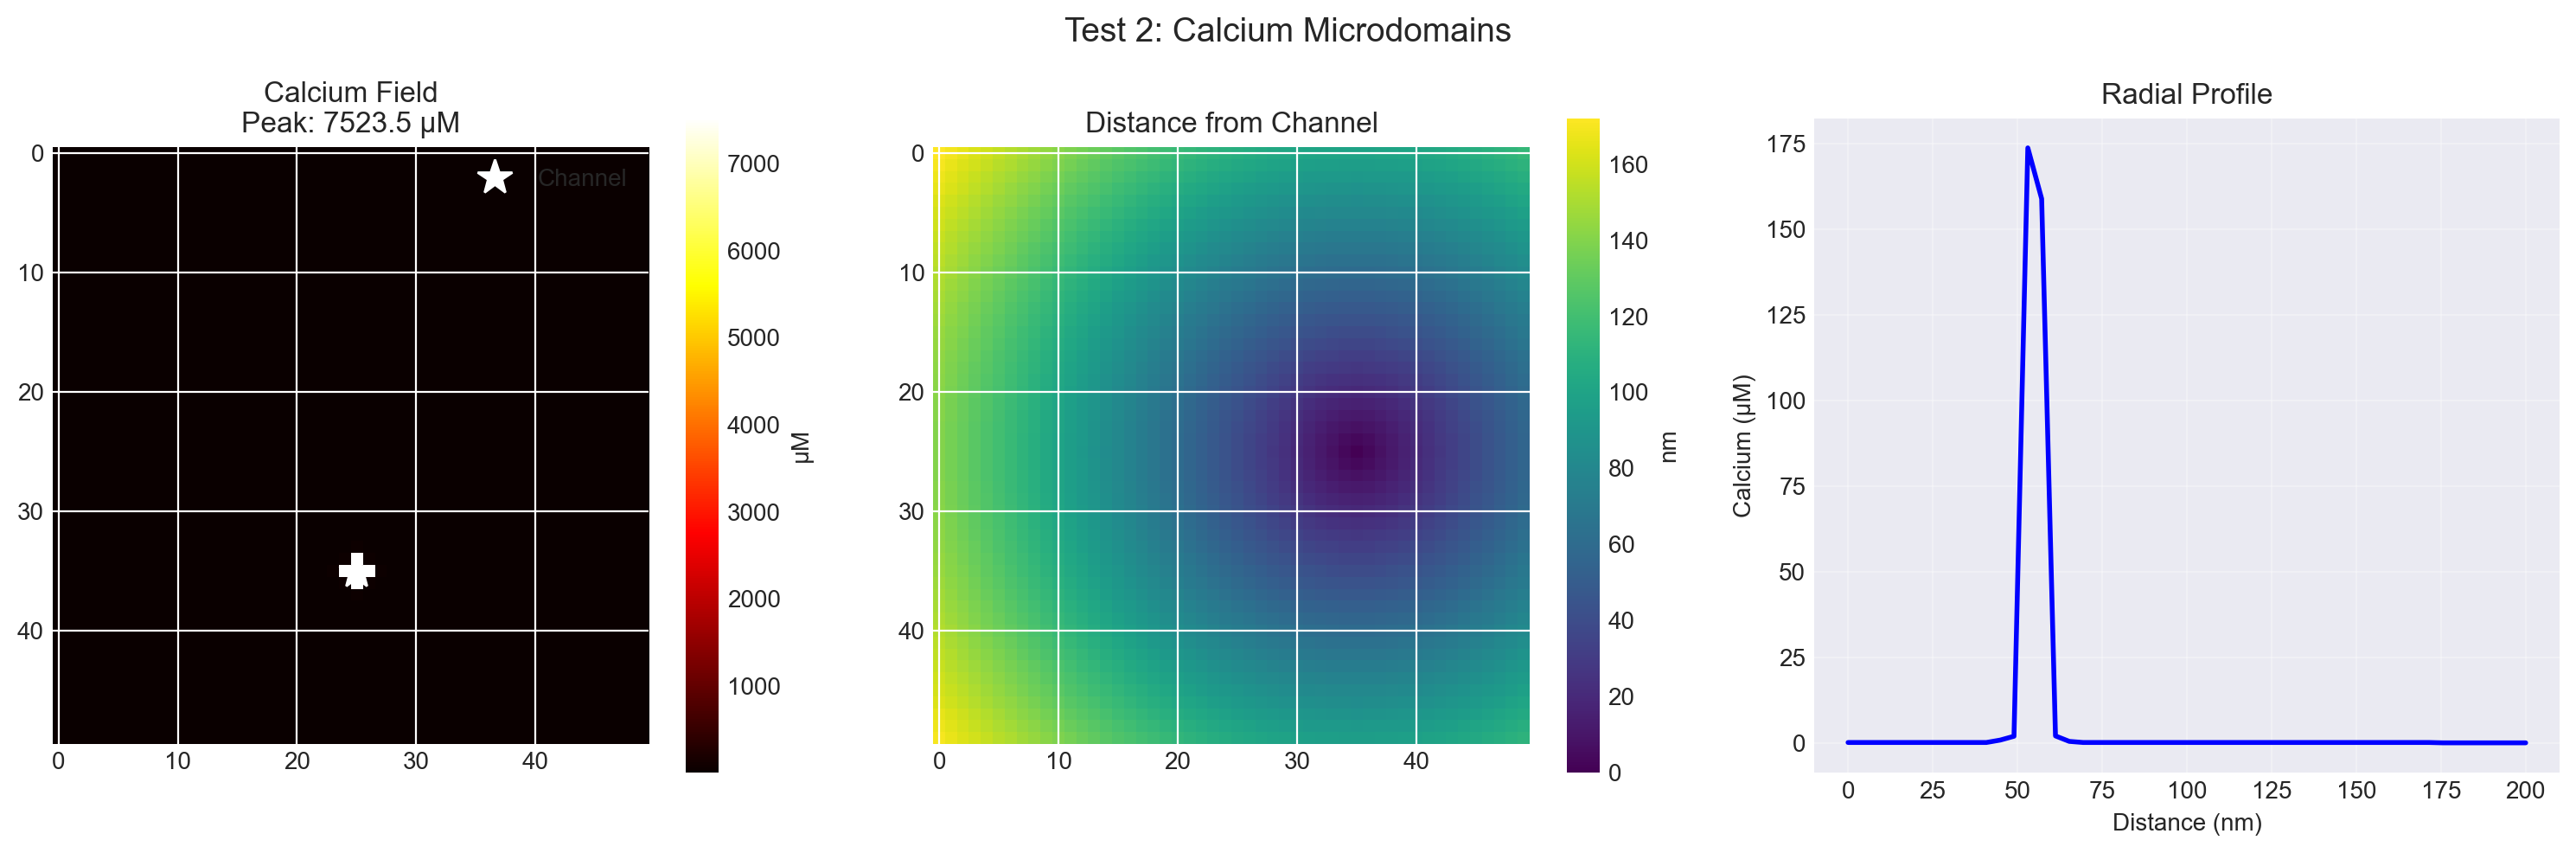

In [31]:
# %% Cell 6: Test 2 - Calcium Microdomains
def test_calcium_microdomains(model):
    """Test calcium channel function and microdomain formation"""

    
    # Force a channel open
    model.channel_states[0] = True
    x, y = model.channel_positions[0]
    model.calcium_field[x, y] = model.params.ca_peak * 100
    
    # Apply diffusion
    model.apply_diffusion_all(1e-5)
    
    # Analysis
    peak_ca = np.max(model.calcium_field)
    mean_ca = np.mean(model.calcium_field)
    
    # Check gradient formation
    dist = model.create_distance_field(x, y)
    near_field = model.calcium_field[dist < 50e-9]
    far_field = model.calcium_field[dist > 100e-9]

    # Debug prints
    print(f"  Peak Ca: {peak_ca*1e6:.1f} µM")
    print(f"  Mean Ca: {mean_ca*1e9:.1f} nM")
    print(f"  Near field mean: {np.mean(near_field)*1e6:.3f} µM")
    print(f"  Far field mean: {np.mean(far_field)*1e9:.3f} nM")
    print(f"  Near/Far ratio: {np.mean(near_field)/np.mean(far_field) if len(far_field) > 0 else 0:.1f}")
    
    gradient_formed = np.mean(near_field) > 1.5 * np.mean(far_field) if len(far_field) > 0 else False
    
    print(f"  Gradient formed: {gradient_formed}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Test 2: Calcium Microdomains', fontsize=14)
    
    # Calcium field
    im1 = axes[0].imshow(model.calcium_field * 1e6, cmap='hot')
    axes[0].plot(y, x, 'w*', markersize=15, label='Channel')
    axes[0].set_title(f'Calcium Field\nPeak: {peak_ca*1e6:.1f} µM')
    axes[0].legend()
    plt.colorbar(im1, ax=axes[0], label='µM')
    
    # Distance field
    im2 = axes[1].imshow(dist * 1e9, cmap='viridis')
    axes[1].set_title('Distance from Channel')
    plt.colorbar(im2, ax=axes[1], label='nm')
    
    # Radial profile
    radii = np.linspace(0, 200, 50)
    profile = []
    for r in radii:
        mask = (dist >= r*1e-9) & (dist < (r+4)*1e-9)
        if np.any(mask):
            profile.append(np.mean(model.calcium_field[mask]))
        else:
            profile.append(0)
    
    axes[2].plot(radii, np.array(profile)*1e6, 'b-', linewidth=2)
    axes[2].set_xlabel('Distance (nm)')
    axes[2].set_ylabel('Calcium (µM)')
    axes[2].set_title('Radial Profile')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return gradient_formed

# Run test
start_time = time.time()
test2_passed = test_calcium_microdomains(model)  # Call directly with model
execution_time = time.time() - start_time

status = "✅ PASSED" if test2_passed else "❌ FAILED"
print(f"\nTest 2: {status} ({execution_time:.2f}s)")
plt.show()


Running pH Modulation Test for Model 5...
Phase 1: Baseline...
Phase 2: High activity...
Phase 3: Recovery...
✅ Data saved: model5/model5_test_1_20250824_182815/test_3_pH_185242/data.json
✅ Figure saved: model5/model5_test_1_20250824_182815/test_3_pH_185242/figure.png
✅ Test run saved to BigQuery: d5d9cb34-b43a-42f7-8167-aa40e9a2349d
✅ Complete save: GCS path=model5/model5_test_1_20250824_182815/test_3_pH_185242, BQ test_id=d5d9cb34-b43a-42f7-8167-aa40e9a2349d

Key Results:
  pH drop: 0.0000 units
  Max calcium: 0.1 µM
  Test passed: False

Test 3: ❌ FAILED (execution time: 2.49s)


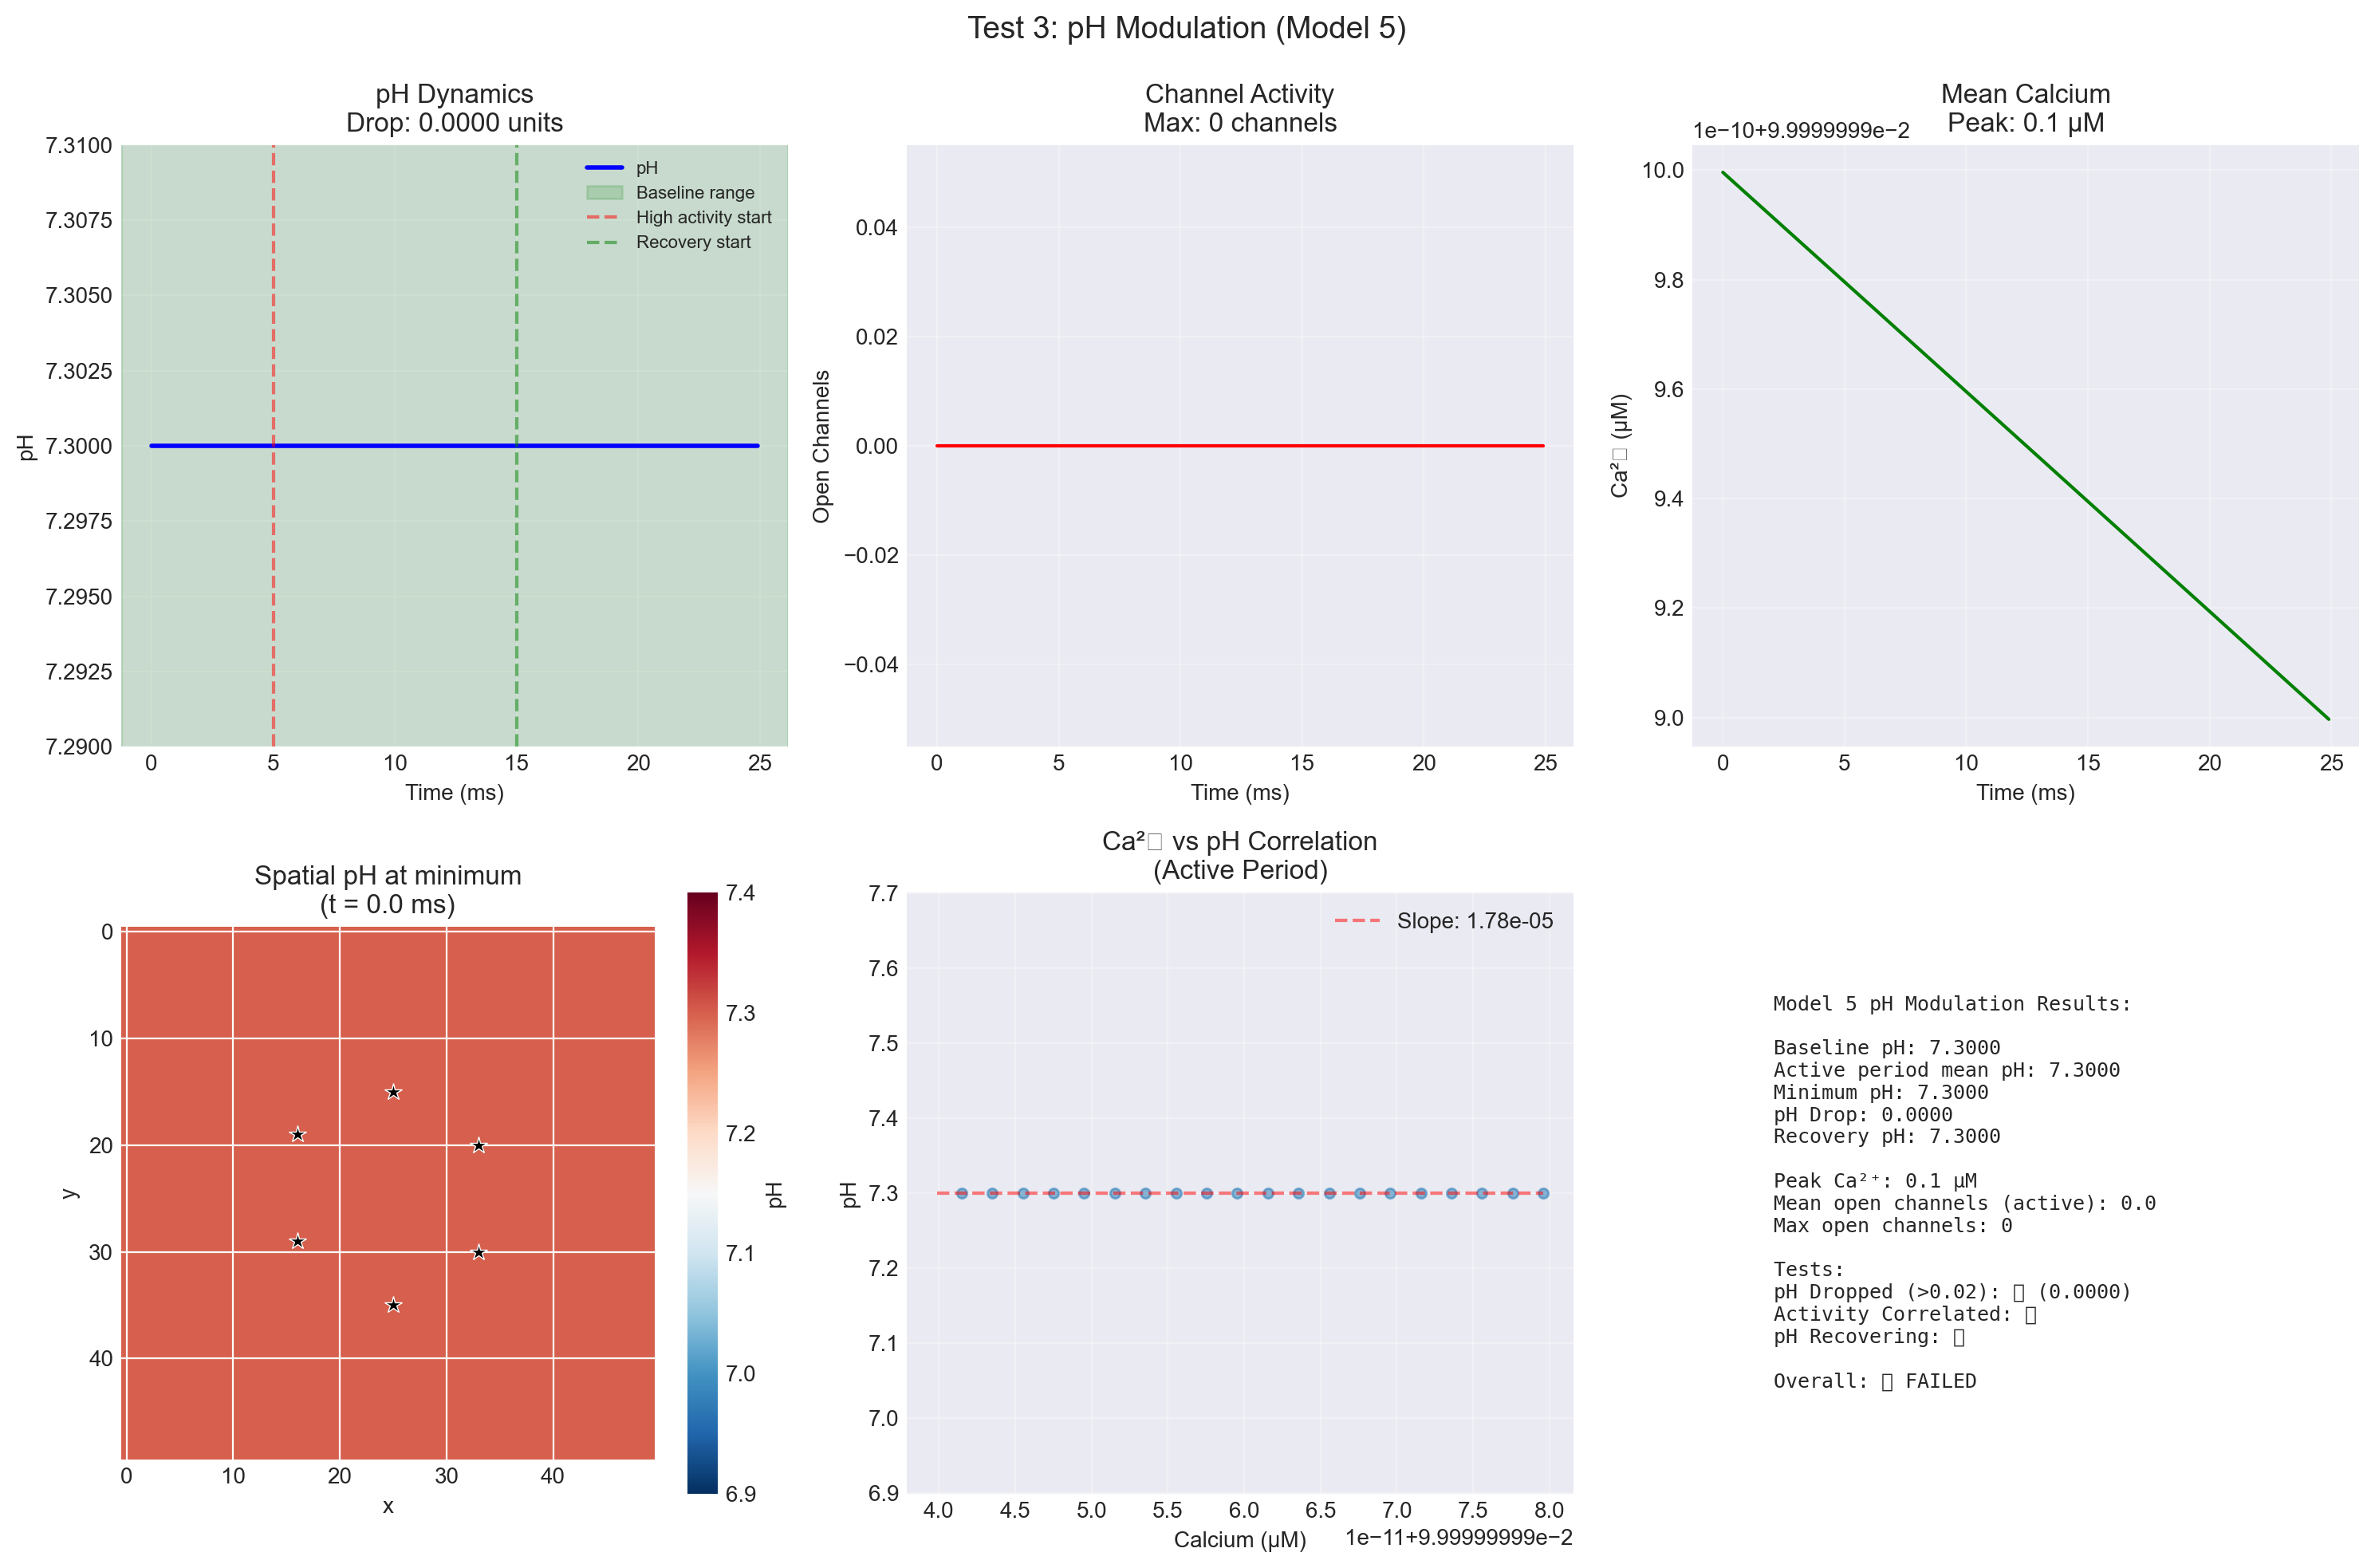

In [42]:
# %% Cell 7: Test 3 - pH Modulation (Final Version for Model 5)
def test_ph_modulation():
    """
    Test activity-dependent pH changes
    Uses Model 5's step() function to maintain all dynamics
    """
    
    # Initialize/reset model to clean state
    model.initialize_fields()
    model.channel_states[:] = False
    model.channel_timers[:] = 0
    
    # Tracking arrays
    pH_history = []
    channel_activity = []
    ca_history = []
    time_points = []
    
    # Phase 1: Baseline period (5 ms) - normal activity
    print("Phase 1: Baseline...")
    for t in range(50):
        model.step(1e-4)  # 0.1 ms timestep
        pH_history.append(np.mean(model.pH_field))
        channel_activity.append(np.sum(model.channel_states))
        ca_history.append(np.mean(model.calcium_field))
        time_points.append(t * 0.1)
    
    # Phase 2: High activity period (10 ms) - increase channel opening
    print("Phase 2: High activity...")
    original_prob = model.params.channel_open_prob
    model.params.channel_open_prob = 0.5  # Increase to 50% open probability
    
    for t in range(100):
        model.step(1e-4)
        pH_history.append(np.mean(model.pH_field))
        channel_activity.append(np.sum(model.channel_states))
        ca_history.append(np.mean(model.calcium_field))
        time_points.append((t + 50) * 0.1)
    
    # Phase 3: Recovery period (10 ms) - return to normal
    print("Phase 3: Recovery...")
    model.params.channel_open_prob = original_prob  # Restore original
    
    for t in range(100):
        model.step(1e-4)
        pH_history.append(np.mean(model.pH_field))
        channel_activity.append(np.sum(model.channel_states))
        ca_history.append(np.mean(model.calcium_field))
        time_points.append((t + 150) * 0.1)
    
    # Analysis
    baseline_pH = np.mean(pH_history[:50])
    active_pH = np.mean(pH_history[50:150])
    min_pH = np.min(pH_history)
    max_ca = np.max(ca_history)
    pH_drop = baseline_pH - min_pH
    recovery_pH = pH_history[-1]
    
    # Success criteria for Model 5
    # We expect pH to drop during high calcium/channel activity
    pH_dropped = pH_drop > 0.02  # At least 0.02 pH units
    pH_activity_correlated = active_pH < baseline_pH  # pH lower during activity
    pH_recovering = recovery_pH > min_pH  # pH recovering after activity
    
    passed = pH_dropped and pH_activity_correlated and pH_recovering
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Test 3: pH Modulation (Model 5)', fontsize=14)
    
    # Main pH dynamics plot
    ax1 = axes[0, 0]
    ax1.plot(time_points, pH_history, 'b-', linewidth=2, label='pH')
    ax1.axhspan(7.25, 7.35, alpha=0.15, color='green', label='Baseline range')
    ax1.axvline(x=5, color='r', linestyle='--', alpha=0.5, label='High activity start')
    ax1.axvline(x=15, color='g', linestyle='--', alpha=0.5, label='Recovery start')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('pH')
    ax1.set_title(f'pH Dynamics\nDrop: {pH_drop:.4f} units')
    ax1.legend(loc='best', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([min(pH_history) - 0.01, max(pH_history) + 0.01])
    
    # Channel activity
    ax2 = axes[0, 1]
    ax2.plot(time_points, channel_activity, 'r-', linewidth=1.5)
    ax2.fill_between(time_points, channel_activity, alpha=0.3, color='red')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Open Channels')
    ax2.set_title(f'Channel Activity\nMax: {max(channel_activity)} channels')
    ax2.grid(True, alpha=0.3)
    
    # Calcium dynamics
    ax3 = axes[0, 2]
    ax3.plot(time_points, np.array(ca_history) * 1e6, 'g-', linewidth=1.5)
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Ca²⁺ (µM)')
    ax3.set_title(f'Mean Calcium\nPeak: {max_ca*1e6:.1f} µM')
    ax3.grid(True, alpha=0.3)
    
    # Spatial pH field at minimum
    min_idx = np.argmin(pH_history)
    im1 = axes[1, 0].imshow(model.pH_field, cmap='RdBu_r', vmin=6.9, vmax=7.4)
    axes[1, 0].set_title(f'Spatial pH at minimum\n(t = {min_idx*0.1:.1f} ms)')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[1, 0], label='pH')
    
    # Mark channel positions
    for (x, y) in model.channel_positions:
        axes[1, 0].plot(y, x, 'k*', markersize=8, markeredgecolor='white', markeredgewidth=0.5)
    
    # pH vs Calcium correlation
    ax5 = axes[1, 1]
    # Bin the data for clearer visualization
    ca_binned = np.array(ca_history[50:150]) * 1e6  # During active period, in µM
    pH_binned = np.array(pH_history[50:150])
    ax5.scatter(ca_binned[::5], pH_binned[::5], alpha=0.5, s=20)  # Plot every 5th point
    ax5.set_xlabel('Calcium (µM)')
    ax5.set_ylabel('pH')
    ax5.set_title('Ca²⁺ vs pH Correlation\n(Active Period)')
    ax5.grid(True, alpha=0.3)
    
    # Add trend line
    if len(ca_binned) > 0 and np.std(ca_binned) > 0:
        z = np.polyfit(ca_binned, pH_binned, 1)
        p = np.poly1d(z)
        ax5.plot(np.sort(ca_binned), p(np.sort(ca_binned)), "r--", alpha=0.5, label=f'Slope: {z[0]:.2e}')
        ax5.legend()
    
    # Summary statistics
    summary_text = f"""
    Model 5 pH Modulation Results:
    
    Baseline pH: {baseline_pH:.4f}
    Active period mean pH: {active_pH:.4f}
    Minimum pH: {min_pH:.4f}
    pH Drop: {pH_drop:.4f}
    Recovery pH: {recovery_pH:.4f}
    
    Peak Ca²⁺: {max_ca*1e6:.1f} µM
    Mean open channels (active): {np.mean(channel_activity[50:150]):.1f}
    Max open channels: {max(channel_activity)}
    
    Tests:
    pH Dropped (>{0.02}): {'✅' if pH_dropped else '❌'} ({pH_drop:.4f})
    Activity Correlated: {'✅' if pH_activity_correlated else '❌'}
    pH Recovering: {'✅' if pH_recovering else '❌'}
    
    Overall: {'✅ PASSED' if passed else '❌ FAILED'}
    """
    
    ax6 = axes[1, 2]
    ax6.text(0.05, 0.5, summary_text, fontsize=9, family='monospace',
             transform=ax6.transAxes, verticalalignment='center')
    ax6.axis('off')
    
    plt.tight_layout()
    
    # Prepare results for saving
    results = {
        'test_passed': passed,
        'test_name': 'pH_modulation',
        'baseline_pH': float(baseline_pH),
        'active_pH': float(active_pH),
        'min_pH': float(min_pH),
        'pH_drop': float(pH_drop),
        'recovery_pH': float(recovery_pH),
        'max_calcium_uM': float(max_ca * 1e6),
        'mean_open_channels_active': float(np.mean(channel_activity[50:150])),
        'max_open_channels': int(max(channel_activity)),
        'pH_dropped': pH_dropped,
        'pH_activity_correlated': pH_activity_correlated,
        'pH_recovering': pH_recovering
    }
    
    # Save results
    save_results_with_bigquery(results, 'test_3_pH')
    
    print(f"\nKey Results:")
    print(f"  pH drop: {pH_drop:.4f} units")
    print(f"  Max calcium: {max_ca*1e6:.1f} µM")
    print(f"  Test passed: {passed}")
    
    return passed

# Run the test
print("Running pH Modulation Test for Model 5...")
start_time = time.time()
test3_passed = test_ph_modulation()
execution_time = time.time() - start_time

status = "✅ PASSED" if test3_passed else "❌ FAILED"
print(f"\nTest 3: {status} (execution time: {execution_time:.2f}s)")
plt.show()